# Définition d'un filtre et stockage des images filtrées

## 1. Chargement des bibliothèques nécessaires

In [2]:
import time
import pandas as pd
import numpy as np
import cv2 # import OpenCV
import matplotlib.pyplot as plt
from tqdm import tqdm #pour barre de temps dans une boucle for
from functions.Filtering import OTSU_threshold, filter_color_threshold,filter_Kmeans1,filter_Kmeans2,filter_MeanShift
from functions.storing import database_generate,database_load
from functions.machine_learning import modeling

from datetime import date

## 2. Visualisation des filtres

OTSU Threshold

Test de ce filtre sur une image, puis application d'une nuance de grix.

Par la suite, on ramènera l'image (363x360) sur un vecteur (1, 130680)

C:\Users\luap_\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=41.644930193747875 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(363, 360, 3)


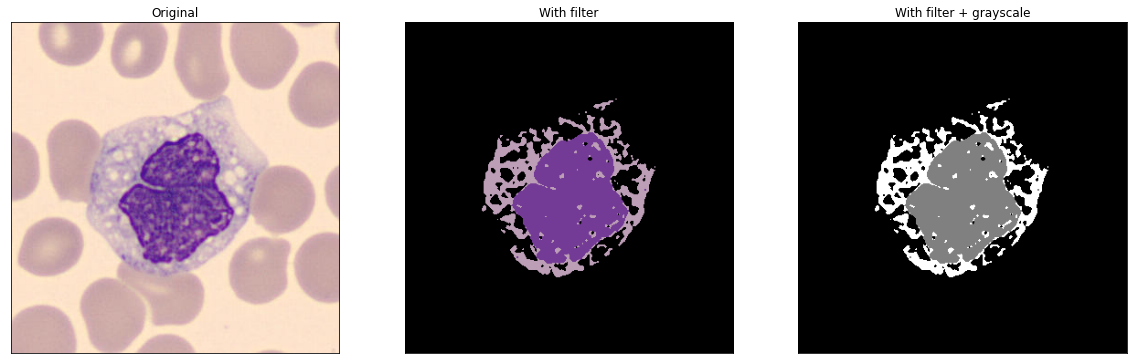

In [3]:
# On choisit K means K=6 pour avoir suffisamment de nuance de grix sur la cellule sélectionnée
# file = df[df.cell_type_code=='MO'].filename.values[100]
# print(file)
# file='data\PBC_dataset_normal_DIB\ig\IG_761306.jpg'
file='C:\\Users\\luap_\\OneDrive\\Data_Science\\Projects\\bloody_spy_blast\\dataset\\PBC_dataset_normal_DIB\\monocyte\\MO_155861.jpg'
img = cv2.imread(file,cv2.IMREAD_COLOR)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# convert with Kmeans filters
# img1, elapsed = OTSU_threshold(img,composant='B')
img1, elapsed = filter_MeanShift(img)
print(img1.shape)

# convert in grayscale
# rgb_weights = [1/3, 1/3, 1/3]
rgb_weights = [0.2989, 0.5870, 0.1140]
img_gray = np.dot(img1[...,:3], rgb_weights)
# img2= img1.mean(axis=0)

plt.figure(figsize = (20, 10))

plt.subplot(1,3,1)
plt.imshow(imgRGB,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(img1,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('With filter')

plt.subplot(1,3,3)
plt.imshow(img_gray,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('With filter + grayscale')

plt.show()

## 3. Formation du dataset pour l'entrainement

Récupération des informations sur la base de données

In [4]:
# path='dataset/PBC_dataset_normal_DIB/'
path='variables/'
img_info = pd.read_csv(path + 'img_info.csv')
cell_types = pd.read_csv(path + 'cell_types.csv')
cell_types['cell_type3']=cell_types.cell_type_code + ' - ' + cell_types.cell_type2
# cell_types = cell_types[cell_types.Source=='article'].drop(columns=['Source'])
df = pd.merge(img_info,cell_types,how='outer') # merge on column cell_subtype
# display(df.head())

# nombre d'images:
print('nb d\'images:',len(df),'\n')
# distribution des types de cellules:
print(df.cell_type3.value_counts(normalize=True).round(4)*100)

nb d'images: 17094 

NE - neutrophils              19.48
EO - eosinophils              18.23
IG - immature granulocytes    16.94
PL - thrombocytes             13.74
ER - erythroblasts             9.07
MO - monocytes                 8.31
BA - basophils                 7.13
LY - lymphocytes               7.10
Name: cell_type3, dtype: float64


In [5]:
len(df.img_name.unique()) # les noms d'image sont bien uniques et peuvent être utilisés comme clé

17094

In [6]:
df.isna().sum()
df[df.filename.isna()]

,filename,cell_type,img_name,cell_subtype_key,img_type,img_dim,img_height,img_width,img_pixels,cell_subtype,cell_type_code,cell_type_label,cell_type1,cell_type2,cell_type3
17093,NaN,platelet,NaN,ERC,NaN,NaN,NaN,NaN,NaN,Thrombocyte aggregation,PL,7,platelets (thrombocytes),thrombocytes,PL - thrombocytes


In [7]:
df.dropna(inplace=True)

**Boucle sur un échantillon de la base de données**

On commence par définir une liste d'indices des lignes que nous allons traiter. On définit un nombre de cellules à traiter par catégorie, et on les sélectionne au hasard parmi la catégorie, puis une boucle traite chaque image et lui applique le filtre ci-dessus et stock la sortie dans une matrice data.

In [8]:
help(database_generate)

Help on function database_generate in module functions.storing:

database_generate(df, sample_per_cell_type, resize_dim, filter_option, savename)
    Description : this function saves a csv file after applying all preprocessing parametered



In [9]:
df_exp=pd.read_csv('variables/prep_info.csv')
idx=df_exp[df_exp.preprocessing_status=='Todo'].index # récupère les indexes des lignes à traiter

for i in idx:
    
    npc=df_exp.loc[i,'sample_per_cell_type'].astype(int)
    resize = tuple([int(x) for x in df_exp.loc[i,'size'].split('x')])
    filter_option = df_exp.loc[i,'filter']
    savename = 'variables/data_prep/data_size-'+str(resize[0])+'x'+str(resize[1])+'_sample-'+str(npc) +'_f-'+filter_option+'.csv'
    
    print('\nSave name:',savename)
    data_df, elapsed_prep, elapsed_save = database_generate(df
                                                   , sample_per_cell_type=npc
                                                   , resize_dim=resize
                                                   , filter_option=filter_option
                                                   , savename=savename)

    df_exp.loc[i,'who']='Paul'
    df_exp.loc[i,'date']=str(date.today())
    df_exp.loc[i,'savename']=savename

    # df_exp.loc[i,'sample_per_cell_type']=npc
    # df_exp.loc[i,'size']=str(resize[0])+'x'+str(resize[1])
    # df_exp.loc[i,'filter']=filter_option

    df_exp.loc[i,'preprocessing_time']=round(elapsed_prep,2)
    df_exp.loc[i,'saving_time']=round(elapsed_save,2)
    
    df_exp.loc[i,'preprocessing_status']='Done'

    df_exp.to_csv('variables/prep_info.csv',index=False)


Save name: variables/data_prep/data_size-90x90_sample-500_f-MeanShift.csv


100%|██████████| 4000/4000 [06:03<00:00, 10.99it/s]


Time elapsed to preprocess: 6.0min 4.0sec
Time elapsed to save csv file: 0.0min 20.0sec

Save name: variables/data_prep/data_size-90x90_sample-1000_f-MeanShift.csv


100%|██████████| 8000/8000 [11:34<00:00, 11.52it/s]


Time elapsed to preprocess: 11.0min 35.0sec
Time elapsed to save csv file: 0.0min 41.0sec


In [29]:
types=[]
for k in df.filename:
    new_type=type(k)
    if new_type not in types:
        types.append(type(k))
        print(k)
types



dataset\PBC_dataset_normal_DIB\basophil\BA_100102.jpg
nan


[str, float]

In [30]:
df.filename.isna().sum()

1

# Loading

In [3]:
# import time
import pandas as pd
# import numpy as np
# import cv2 # import OpenCV
# import matplotlib.pyplot as plt
# from tqdm import tqdm #pour barre de temps dans une boucle for
# from functions.Filtering import OTSU_threshold, filter_color_threshold,filter_Kmeans1,filter_Kmeans2,filter_MeanShift
from functions.storing import database_generate,database_load
from functions.machine_learning import modeling

# from datetime import date

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [4]:
df_exp=pd.read_csv('variables/prep_info.csv')
# df_exp.savename.dropna()
df_exp.head()

,who,date,savename,sample_per_cell_type,size,filter,preprocessing_status,preprocessing_time,saving_time,training_status,pca,pca_components,loading_time,train_test_split_time,RF_time,RF_train_acc,RF_test_acc,SVM_time,SVM_train_acc,SVM_test_acc
0,Emilien,17/12/2021,NaN,50.0,360x360,rgb,Done,NaN,836.11,Done,no,NaN,/,73.29,48.27,NaN,0.775,65.91,NaN,0.663
1,Emilien,17/12/2021,NaN,50.0,180x180,rgb,Done,NaN,163.34,Done,no,NaN,36.24,7.07,9.05,NaN,0.75,14.89,NaN,0.663
2,Emilien,17/12/2021,NaN,50.0,90x90,rgb,Done,NaN,18.93,Done,no,NaN,3.08,0.05,1.45,NaN,0.663,2.33,NaN,0.563
3,Emilien,17/12/2021,NaN,300.0,360x360,rgb,Done,NaN,OUT OF MEMORY,Done,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Emilien,17/12/2021,NaN,300.0,180x180,rgb,Done,NaN,2080.76,Done,no,NaN,214.06,2.07,107.32,NaN,0.814,238.99,NaN,0.731


In [6]:
df_exp=pd.read_csv('variables/prep_info.csv')
idx=df_exp[df_exp.training_status=='Todo'].index # récupère les indexes des lignes à traiter
# idx=df_exp[df_exp.Training_status=='Todo' & df_exp.savename.isna()==False].index

for i in idx:
    
    savename = df_exp.loc[i,'savename']
    size = tuple([int(x) for x in df_exp.loc[i,'size'].split('x')])
    print(f'Training database {savename}')

    data_df, elapsed_load = database_load(savename,size)

    df_exp.loc[i,'loading_time']=round(elapsed_load,2)
    
    target = data_df['label'].apply(lambda x: x.split(' - ')[0])
    feats = data_df.iloc[:,2:]

    if df_exp.loc[i,'pca'] == 'yes':
        # AVEC PCA
        pca=PCA(n_components =0.9).fit(feats)
        df_exp.loc[i,'pca_components']=pca.n_components_
        # print('number of pixels kept:',pca.n_components_)
        feats=pca.transform(feats)

    # Entrainement d'un SVM
    acc_train,acc_test,elapsed_train = modeling(feats,target,svm.SVC(),display_results_list=[])
    
    # Enregistrement des résulats
    df_exp.loc[i,'SVM_time']=round(elapsed_train,2)
    df_exp.loc[i,'SVM_train_acc']=round(acc_train,3)
    df_exp.loc[i,'SVM_test_acc']=round(acc_test,3)
    
    # Entrainement d'un RF
    # rf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20) # on limite le nombre de feuilles et la profondeur pour éviter l'overfitting
    # rf = RandomForestClassifier(max_depth=10)
    rf = RandomForestClassifier()
    acc_train,acc_test,elapsed_train = modeling(feats,target,rf,display_results_list=[])
    
    # Enregistrement des résulats
    df_exp.loc[i,'RF_time']=round(elapsed_train,2)
    df_exp.loc[i,'RF_train_acc']=round(acc_train,3)
    df_exp.loc[i,'RF_test_acc']=round(acc_train,3)

    df_exp.loc[i,'training_status']='Done'

    df_exp.to_csv('variables/prep_info.csv',index=False)

Training database variables/data_prep/data_size-90x90_sample-50_f-Kmeans1.csv
Time elapsed to load variables/data_prep/data_size-90x90_sample-50_f-Kmeans1.csv: 0.0min 1.0sec
Time elapsed to train model: 0.0min 2.0sec
Time elapsed to train model: 0.0min 0.0sec
Training database variables/data_prep/data_size-180x180_sample-50_f-Kmeans1.csv
Time elapsed to load variables/data_prep/data_size-180x180_sample-50_f-Kmeans1.csv: 0.0min 2.0sec
Time elapsed to train model: 0.0min 0.0sec
Time elapsed to train model: 0.0min 0.0sec
Training database variables/data_prep/data_size-60x60_sample-100_f-Kmeans1.csv
Time elapsed to load variables/data_prep/data_size-60x60_sample-100_f-Kmeans1.csv: 0.0min 0.0sec
Time elapsed to train model: 0.0min 2.0sec
Time elapsed to train model: 0.0min 0.0sec
Training database variables/data_prep/data_size-90x90_sample-100_f-Kmeans1.csv
Time elapsed to load variables/data_prep/data_size-90x90_sample-100_f-Kmeans1.csv: 0.0min 1.0sec
Time elapsed to train model: 0.0min 7.